# MobileViT Offline Processing

On-device training requires steps that happen off the device, referred to as "offline" steps. 

This notebook contains the offline processing steps for an example using MobileViT for facial expression recognition.

## Training artifact generation

In order to train on the device, the following files are required: a model checkpoint with the weights, the training model ONNX file, the optimizer ONNX file, and the evaluation model ONNX file. 

The generate_artifacts method simplifies this process, allowing you to pass in an initial ONNX model (for example, imported from HuggingFace Transformers), specify a loss type and optimizer (both required), and will generate the required training artifacts for you.

The parameters that require gradient and the frozen parameters are taken from the initial PyTorch model.

Before passing to the generate_artifacts function, the model is configured to suit the dataset: for example, the random input that the model is built off of has the same image dimensions as the dataset images, and the number of labels is configured to reflect the dataset. 

Although this example uses PyTorch to export a HuggingFace Transformers model into an ONNX file to be passed to generate_artifacts, any method of creating or exporting an ONNX file can be used with generate_artifacts.

In [1]:
import torch
import transformers
import onnx
from onnxruntime.training import artifacts
import numpy

In [2]:
# change the configuration to reflect the number of labels used in the dataset
config = transformers.MobileViTConfig.from_pretrained("apple/mobilevit-xx-small", num_labels=7)
model = transformers.MobileViTForImageClassification.from_pretrained("apple/mobilevit-xx-small", config=config, ignore_mismatched_sizes=True)

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-xx-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 320]) in the checkpoint and torch.Size([7, 320]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Note: the random input generated should follow the shape / dimensions of the images you will train on. The training artifact generation step will fail if the width and height of the random input are not powers of 2. However you choose to process your images, they should 

In [3]:
onnx_name = "mobilevit_init_test.onnx"

# generates random pixel values for 5 images
# originally images were 256 by 256
random_input = {"pixel_values": torch.rand(5, 3, 256, 256)}

torch.onnx.export(model, random_input, onnx_name,
                    input_names=["pixel_values"], output_names=["output"],
                    export_params=True,
                    dynamic_axes={
                        "pixel_values": {0: "batch_size"},
                        "output": {0: "batch_size"}
                    },
                    do_constant_folding=False,
                    training=torch.onnx.TrainingMode.TRAINING,
                    opset_version=12)

/bert_ort/carolinezhu/e2edemos/lib/python3.9/site-packages/transformers/models/mobilevit/modeling_mobilevit.py:452: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  new_height = int(math.ceil(orig_height / patch_height) * patch_height)
/bert_ort/carolinezhu/e2edemos/lib/python3.9/site-packages/transformers/models/mobilevit/modeling_mobilevit.py:453: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  new_width = int(math.ceil(orig_width / patch_width) * patch_width)
/bert_ort/carolinezhu/e2edemos/lib/python3.9/site-packages/transformers/models/mobilevit/modeling_mo

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [4]:
requires_grad = []
frozen_params = []
for name, param in model.named_parameters():
    if param.requires_grad:
        requires_grad.append(name)
    else:
        frozen_params.append(name)

for name, param in model.named_buffers():
    frozen_params.append(name)

onnx_model = onnx.load(onnx_name)

artifacts.generate_artifacts(
    onnx_model,
    optimizer=artifacts.OptimType.AdamW,
    loss=artifacts.LossType.CrossEntropyLoss,
    requires_grad=requires_grad,
    frozen_params=frozen_params
)

2023-04-25 21:21:50.859698460 [I:onnxruntime:Default, constant_sharing.cc:257 ApplyImpl] Total shared scalar initializer count: 153
2023-04-25 21:21:50.880536762 [I:onnxruntime:Default, graph.cc:3546 CleanUnusedInitializersAndNodeArgs] Removing initializer 'ortshared_1_0_1_3'. It is no longer used by any node.
2023-04-25 21:21:50.880556561 [I:onnxruntime:Default, graph.cc:3546 CleanUnusedInitializersAndNodeArgs] Removing initializer 'ortshared_1_0_1_0'. It is no longer used by any node.
2023-04-25 21:21:50.897549929 [I:onnxruntime:Default, graph.cc:3546 CleanUnusedInitializersAndNodeArgs] Removing initializer 'ortshared_7_0_1_13'. It is no longer used by any node.
2023-04-25 21:21:50.897564428 [I:onnxruntime:Default, graph.cc:3546 CleanUnusedInitializersAndNodeArgs] Removing initializer 'ortshared_7_0_1_12'. It is no longer used by any node.
2023-04-25 21:21:50.897568828 [I:onnxruntime:Default, graph.cc:3546 CleanUnusedInitializersAndNodeArgs] Removing initializer 'ortshared_7_0_1_11'.

In [7]:

training_model_path = 'training_model.onnx'

training_onnx = onnx.load(training_model_path)
training_onnx.opset_import[3]

domain: "com.ms.internal.nhwc"
version: 19

In [10]:
# op = onnx.OperatorSetIdProto()
# op.version = 12

# update_model = onnx.helper.make_model(training_onnx.graph, opset_imports=[op])

# update_model.opset_import

training_onnx.opset_import[3].version = 12
training_onnx.opset_import 



onnx.save(training_onnx, 'training_model_updated.onnx')

In [3]:
from onnx import version_converter, helper

training_converted = version_converter.convert_version(training_onnx, 12)

training_converted.opset_import

[domain: ""
version: 12
, domain: "ai.onnx.ml"
version: 3
, domain: "ai.onnx.training"
version: 1
, domain: "com.ms.internal.nhwc"
version: 19
, domain: "ai.onnx.preview.training"
version: 1
, domain: "com.microsoft"
version: 1
, domain: "com.microsoft.experimental"
version: 1
, domain: "com.microsoft.nchwc"
version: 1
, domain: "org.pytorch.aten"
version: 1
]

In [6]:
from onnxruntime_extensions import pnp
pre = pnp.PreMobileNet(size=256)

In [26]:
short = numpy.asarray(dataset['train']['image'][:10])

/tmp/ipykernel_3989479/1368368030.py:1: FutureWarning: The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  short = numpy.asarray(dataset['train']['image'][:10])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

In [9]:
pre_name = "preprocessing.onnx"
tmp_img = numpy.asarray(dataset['train']['image'][0]).tolist()
torch.onnx.export(pre, tmp_img, pre_name,
                    input_names=["image"], output_names=["output"],
                    export_params=True,
                    dynamic_axes={
                        "image": {0: "width", 1: "height"},
                        "output": {0: "batch_size"}
                    },
                    do_constant_folding=False,
                    training=torch.onnx.TrainingMode.TRAINING,
                    opset_version=12)

/bert_ort/carolinezhu/e2edemosclone/lib/python3.9/site-packages/onnxruntime_extensions/pnp/_imagenet.py:23: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  img = torch.tensor(img)
/bert_ort/carolinezhu/e2edemosclone/lib/python3.9/site-packages/onnxruntime_extensions/pnp/_imagenet.py:24: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert img.shape[-1] == 3, 'the input image should be in RGB channels'
/bert_ort/carolinezhu/e2edemosclone/lib/python3.9/site-packages/onnxruntime_extensions/pnp/_imagenet.py:29: TracerWar

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ValueError: This ORT build has ['CUDAExecutionProvider', 'CPUExecutionProvider'] enabled. Since ORT 1.9, you are required to explicitly set the providers parameter when instantiating InferenceSession. For example, onnxruntime.InferenceSession(..., providers=['CUDAExecutionProvider', 'CPUExecutionProvider'], ...)

In [4]:
from datasets import load_dataset

dataset = load_dataset("FER-Universe/DiffusionFER")

Found cached dataset imagefolder (/home/carolinezhu/.cache/huggingface/datasets/FER-Universe___imagefolder/FER-Universe--DiffusionFER-584755ddb54e5e9f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
pre.forward(np_img)

/bert_ort/carolinezhu/e2edemosclone/lib/python3.9/site-packages/onnxruntime_extensions/pnp/_onnx_ops.py:71: UserWarning: The maximum opset needed by this model is only 9.
  warnings.warn('The maximum opset needed by this model is only %d.' % op_version)


ValueError: This ORT build has ['CUDAExecutionProvider', 'CPUExecutionProvider'] enabled. Since ORT 1.9, you are required to explicitly set the providers parameter when instantiating InferenceSession. For example, onnxruntime.InferenceSession(..., providers=['CUDAExecutionProvider', 'CPUExecutionProvider'], ...)

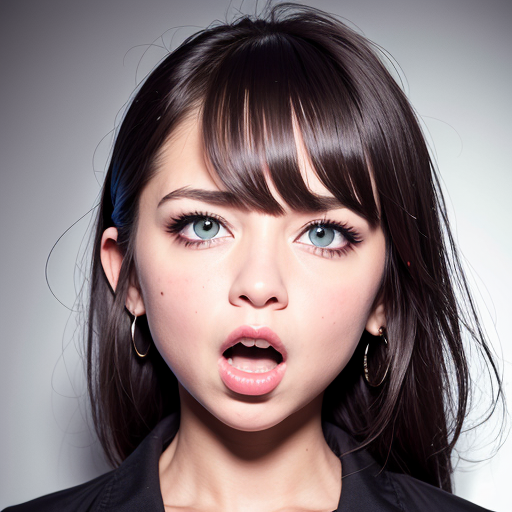

In [12]:
dataset['train']['image'][2580]

In [15]:
rgb_np = numpy.asarray(dataset['train']['image'][2580].convert('RGB'))
rgb_np

array([[[ 67,  62,  70],
        [ 66,  62,  71],
        [ 66,  62,  71],
        ...,
        [102, 100, 109],
        [101, 100, 110],
        [100,  97, 107]],

       [[ 68,  63,  72],
        [ 67,  62,  71],
        [ 67,  63,  71],
        ...,
        [103,  99, 109],
        [102,  99, 109],
        [101, 100, 110]],

       [[ 68,  63,  71],
        [ 68,  64,  71],
        [ 67,  64,  72],
        ...,
        [103, 101, 110],
        [102, 100, 108],
        [103,  99, 110]],

       ...,

       [[160, 162, 177],
        [167, 169, 181],
        [134, 137, 149],
        ...,
        [249, 249, 251],
        [248, 250, 251],
        [250, 250, 253]],

       [[154, 157, 171],
        [114, 120, 130],
        [ 44,  52,  61],
        ...,
        [249, 250, 251],
        [250, 251, 252],
        [247, 249, 251]],

       [[ 94,  97, 118],
        [ 25,  29,  46],
        [  3,   9,  20],
        ...,
        [249, 250, 253],
        [250, 253, 253],
        [248, 249, 252]]

In [16]:

np_img = numpy.asarray(dataset['train']['image'][2580])
np_img

array([[[ 67,  62,  70],
        [ 66,  62,  71],
        [ 66,  62,  71],
        ...,
        [102, 100, 109],
        [101, 100, 110],
        [100,  97, 107]],

       [[ 68,  63,  72],
        [ 67,  62,  71],
        [ 67,  63,  71],
        ...,
        [103,  99, 109],
        [102,  99, 109],
        [101, 100, 110]],

       [[ 68,  63,  71],
        [ 68,  64,  71],
        [ 67,  64,  72],
        ...,
        [103, 101, 110],
        [102, 100, 108],
        [103,  99, 110]],

       ...,

       [[160, 162, 177],
        [167, 169, 181],
        [134, 137, 149],
        ...,
        [249, 249, 251],
        [248, 250, 251],
        [250, 250, 253]],

       [[154, 157, 171],
        [114, 120, 130],
        [ 44,  52,  61],
        ...,
        [249, 250, 251],
        [250, 251, 252],
        [247, 249, 251]],

       [[ 94,  97, 118],
        [ 25,  29,  46],
        [  3,   9,  20],
        ...,
        [249, 250, 253],
        [250, 253, 253],
        [248, 249, 252]]

In [18]:
short = []
for image in dataset['train']['image'][:10]:
    new_img = numpy.asarray(image).tolist()
    short.append(new_img)
    # print(len(new_img))
    # print(len(new_img[0]))
    print(type(new_img[0]))

print(short)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
[[[[95, 80, 58], [96, 81, 59], [98, 82, 61], [99, 82, 62], [93, 76, 57], [92, 74, 56], [93, 76, 57], [96, 82, 59], [97, 82, 60], [98, 81, 60], [98, 80, 60], [97, 82, 59], [98, 81, 60], [99, 80, 62], [100, 79, 63], [102, 82, 66], [98, 80, 66], [82, 65, 54], [53, 36, 26], [44, 28, 20], [47, 31, 22], [52, 35, 25], [53, 32, 23], [69, 46, 36], [78, 56, 45], [78, 59, 47], [66, 46, 37], [68, 49, 37], [83, 60, 45], [104, 74, 59], [115, 79, 65], [124, 88, 74], [133, 98, 84], [143, 105, 92], [141, 106, 92], [134, 100, 86], [122, 91, 77], [111, 83, 68], [104, 79, 64], [99, 77, 61], [95, 74, 58], [88, 67, 52], [78, 57, 47], [69, 48, 42], [63, 43, 37], [63, 45, 40], [58, 42, 37], [50, 33, 30], [38, 21, 19], [37, 21, 17], [39, 22, 17], [42, 24, 20], [48, 27, 26], [50, 30, 25], [53, 32, 27], [55, 34, 30], [57, 36, 28], [64, 41, 33], [69, 45, 37], [70, 4